In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import argparse
import time
from tqdm import tqdm
import os
%matplotlib inline
from sklearn.decomposition import TruncatedSVD
from matplotlib import style

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sns.set(style='dark')

In [4]:
df=pd.read_csv('normal dataset (no normalize).csv')
df.head()

,MeasureMRM12,MeasureMRM30,MeasureMRM204,MeasureMRM205,MeasureMRM143,MeasureMRM187,MeasureMRM188,MeasureMRM144,ReservoirTemperature_c,ProducingGOR_m3_t,LiquidViscosity,WeightedParticlesFactor_mg_l
0,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
1,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
2,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
3,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
4,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0


In [5]:
anom=pd.read_csv('anomaly dataset (no normalize).csv')
anom.head()

,MeasureMRM12,MeasureMRM30,MeasureMRM204,MeasureMRM205,MeasureMRM143,MeasureMRM187,MeasureMRM188,MeasureMRM144,ReservoirTemperature_c,ProducingGOR_m3_t,LiquidViscosity,WeightedParticlesFactor_mg_l
0,41.0,0.82,8.9,10.9,8.2,66.0,26.1,51.0,60.0,103.0,1.53,125.0
1,42.0,0.83,0.0,0.0,8.3,66.0,26.5,51.0,60.0,103.0,1.53,125.0
2,42.0,0.85,0.0,0.0,8.3,66.0,27.0,51.0,60.0,103.0,1.53,125.0
3,41.0,0.83,8.0,9.6,8.3,66.0,27.0,51.0,60.0,103.0,1.53,125.0
4,41.0,0.81,0.0,0.0,8.3,66.0,27.9,51.0,60.0,103.0,1.53,125.0


In [6]:
df.columns

Index(['MeasureMRM12', 'MeasureMRM30', 'MeasureMRM204', 'MeasureMRM205',
       'MeasureMRM143', 'MeasureMRM187', 'MeasureMRM188', 'MeasureMRM144',
       'ReservoirTemperature_c', 'ProducingGOR_m3_t', 'LiquidViscosity',
       'WeightedParticlesFactor_mg_l'],
      dtype='object')

In [7]:
columns=df.columns

In [8]:
df.shape

(600701, 12)

In [9]:
df.head()

,MeasureMRM12,MeasureMRM30,MeasureMRM204,MeasureMRM205,MeasureMRM143,MeasureMRM187,MeasureMRM188,MeasureMRM144,ReservoirTemperature_c,ProducingGOR_m3_t,LiquidViscosity,WeightedParticlesFactor_mg_l
0,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
1,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
2,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
3,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0
4,55.0,5.83,5.0,2.1,17.0,55.5,25.7,0.0,60.0,70.0,1.64,132.0


In [10]:
anom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48667 entries, 0 to 48666
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   MeasureMRM12                  48667 non-null  float64
 1   MeasureMRM30                  48667 non-null  float64
 2   MeasureMRM204                 48667 non-null  float64
 3   MeasureMRM205                 48667 non-null  float64
 4   MeasureMRM143                 48667 non-null  float64
 5   MeasureMRM187                 48667 non-null  float64
 6   MeasureMRM188                 48667 non-null  float64
 7   MeasureMRM144                 48667 non-null  float64
 8   ReservoirTemperature_c        48667 non-null  float64
 9   ProducingGOR_m3_t             48667 non-null  float64
 10  LiquidViscosity               48667 non-null  float64
 11  WeightedParticlesFactor_mg_l  48667 non-null  float64
dtypes: float64(12)
memory usage: 4.5 MB


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600701 entries, 0 to 600700
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   MeasureMRM12                  600701 non-null  float64
 1   MeasureMRM30                  600701 non-null  float64
 2   MeasureMRM204                 600701 non-null  float64
 3   MeasureMRM205                 600701 non-null  float64
 4   MeasureMRM143                 600701 non-null  float64
 5   MeasureMRM187                 600701 non-null  float64
 6   MeasureMRM188                 600701 non-null  float64
 7   MeasureMRM144                 600701 non-null  float64
 8   ReservoirTemperature_c        600701 non-null  float64
 9   ProducingGOR_m3_t             600701 non-null  float64
 10  LiquidViscosity               600701 non-null  float64
 11  WeightedParticlesFactor_mg_l  600701 non-null  float64
dtypes: float64(12)
memory usage: 55.0 MB


In [12]:
tsvd2D = TruncatedSVD(n_components=3)
tsvd2D.fit(df)
df_SVD=pd.DataFrame(tsvd2D.transform(df))

In [13]:
anomalies_SVD = pd.DataFrame(tsvd2D.transform(anom))

In [14]:
# # Установка стиля Seaborn v0.8
# sns.set(style='dark')

# # Создание фигуры и осей
# fig, ax = plt.subplots(figsize=(8, 6))

# # Построение точек аномальных данных
# ax.scatter(anomalies_SVD.values[:, 0], anomalies_SVD.values[:, 1], color='red', label='Anomalies', alpha=0.5)

# # Построение точек чистых данных
# ax.scatter(df_SVD.values[:, 0], df_SVD.values[:, 1], color='green', label='Normal', alpha=0.5)

# # Добавление легенды
# ax.legend()

# # Установка заголовка и меток осей
# ax.set_title('Anomalies and Normal Data', fontsize=16)
# ax.set_xlabel('X1', fontsize=14)
# ax.set_ylabel('X2', fontsize=14)

# # Отображение графика
# plt.show()

In [15]:
df_SVD

,0,1,2
0,23.935114,1.377093,136.322717
1,23.935114,1.377093,136.322717
2,23.935114,1.377093,136.322717
3,23.935114,1.377093,136.322717
4,23.935114,1.377093,136.322717
...,...,...,...
600696,19.085928,25.659391,82.839987
600697,19.085928,25.659391,82.839987
600698,19.085928,25.659391,82.839987
600699,19.085928,25.659391,82.839987


In [16]:
anomalies_SVD

,0,1,2
0,30.430187,9.623739,132.539618
1,19.083145,1.490749,134.566494
2,19.090672,1.494942,134.624657
3,29.234554,8.622305,132.767655
4,19.018026,1.543140,133.890766
...,...,...,...
48662,622.343116,102.134199,42.373904
48663,11.639039,2.188878,75.827390
48664,11.723829,2.148788,76.654782
48665,59.666771,13.160649,98.421304


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Создаем экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем данные в датафрейме X
df = pd.DataFrame(scaler.fit_transform(df_SVD))
anom=pd.DataFrame(scaler.fit_transform(anomalies_SVD))

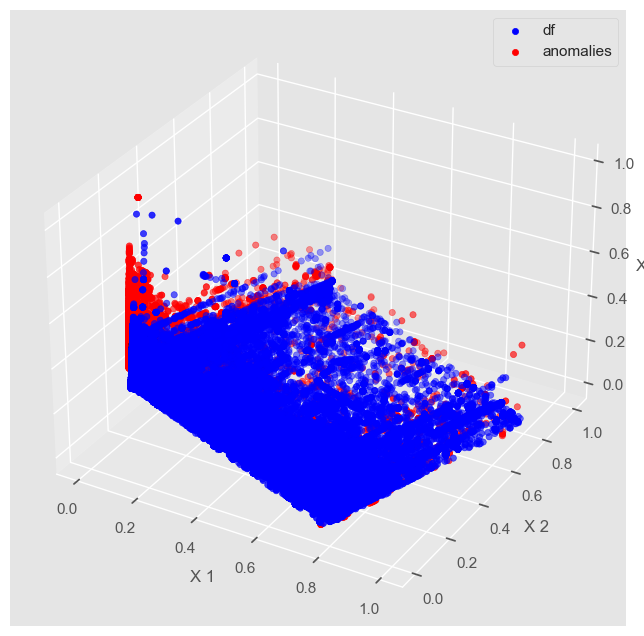

In [18]:
style.use('ggplot')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[0], df[1], df[2], c='blue', label='df')

ax.scatter(anom[0], anom[1], anom[2], c='red', label='anomalies')

ax.set_xlabel('X 1')
ax.set_ylabel('X 2')
ax.set_zlabel('X 3')
ax.legend()
# plt.savefig('3dplot.png', dpi=300)
plt.show()

In [19]:
# for i in df.columns:
#     plt.figure()
#     plt.title(f"{i}")
#     plt.plot((df_fft[i]), c='blueviolet', label='FFT')
#     plt.plot(df[i], c='orange', label='original')
#     plt.title(f"Lineplot for {i}")
#     plt.legend()
#     plt.xlabel("Frequency Bins")
#     plt.ylabel("Amplitude")
#     plt.show()

In [18]:
class encdataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=32):
        # data load
        self.data = data
        self.features = self.data.values.astype(np.float32)
        self.n_samples, self.n_features = self.data.shape
        self.seq_len = seq_len
        self.train_df = self.data[0:576000]
        self.val_df = self.data[576000:]
        
        # создание датасета
        self.train_dataset = self.create_dataset(self.train_df, batch_size)
        self.val_dataset = self.create_dataset(self.val_df, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data[i:i+self.seq_len].values  # Изменение здесь
            sequences.append(torch.from_numpy(sequence))
        dataset = DataLoader(sequences, batch_size=batch_size, shuffle=False)
        return dataset

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return self.n_samples


In [19]:
dataset = encdataset(df)
train_loader = dataset.train_dataset
val_loader = dataset.val_dataset
seq_len = dataset.seq_len
n_features = dataset.n_features

In [20]:
# for batch in train_loader:
#     print(batch)
#     print(batch.shape)

In [21]:
seq_len

1

In [22]:
n_features

3

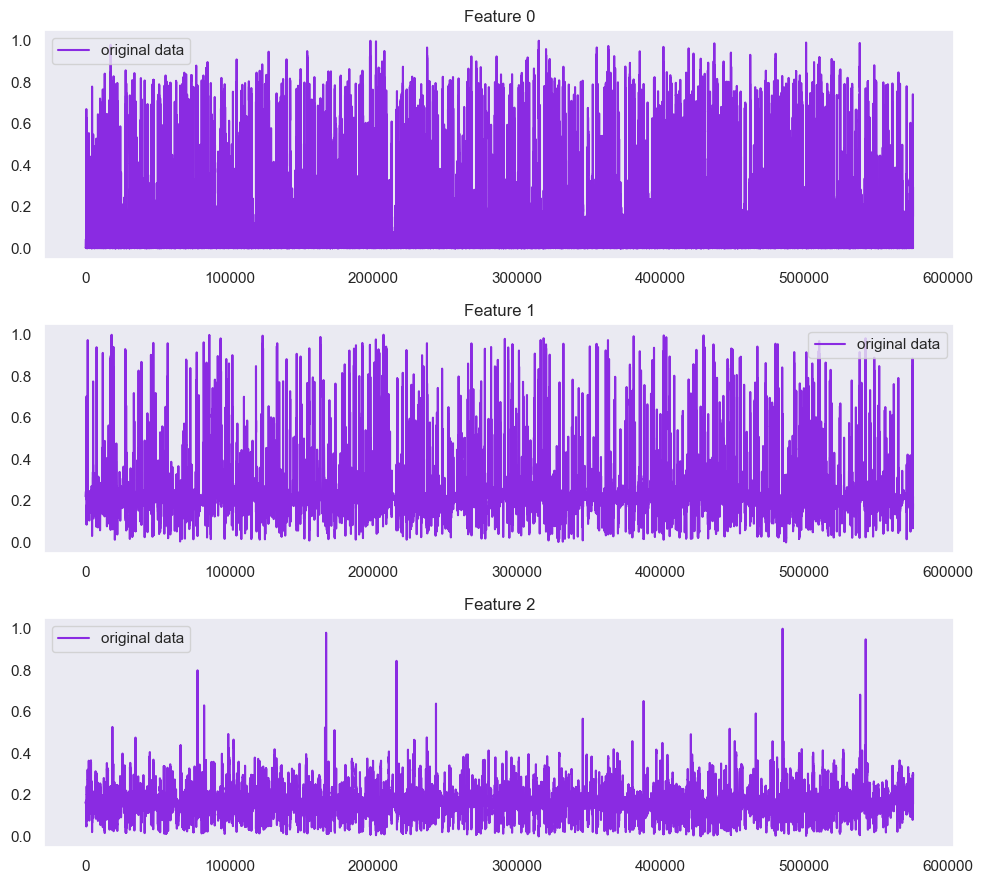

In [23]:
# 1. Извлечь данные из train_loader в виде numpy массива
train_data = []
for batch in train_loader:
    batch = batch.squeeze(1)  # убираем лишнее измерение
    batch = batch.numpy()  # преобразуем в numpy array
    for seq in batch:
        train_data.append(seq)
train_data = np.array(train_data)

# 2. Перестроить данные в подходящий формат для построения графиков
train_data = train_data.reshape(-1, seq_len, n_features)

# 3. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 4. Построить график для каждой фичи
for i in range(n_features):
    line, = axs[i].plot(train_data[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(train_data[:, j, i], color='blueviolet')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line])  # Добавить легенду

plt.tight_layout()
plt.show()

In [24]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args('')

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ===== data loading ==== #
args.batch_size = 32

# ==== model capacity ==== #
args.n_layers = 1
args.embedding_dim = 128


# ==== regularization ==== #
# args.dropout = 0  # Установка значения dropout
args.use_bn = False  # batch normalization

# ==== optimizer & training  # ====
args.lr = 0.001
args.epoch = 180
args.patience = 20

In [25]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim = 2 * args.embedding_dim
        self.lstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=args.n_layers,
            batch_first=True,
            dtype=torch.float32
        ).to(args.device)
        self.lstm2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=args.embedding_dim,
            num_layers=args.n_layers,
            batch_first=True,
            dtype=torch.float32
        ).to(args.device)

    def forward(self, x):
        x = x.to(args.device).to(torch.float32)
        batch_size = x.size(0)

        # print(f'ENCODER input dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.n_features))
        # print(f'ENCODER reshaped dim: {x.shape}')
        x, (_, _) = self.lstm1(x)
        # print(f'ENCODER output lstm1 dim: {x.shape}')
        x, (hidden_n, _) = self.lstm2(x)
        # print(f'ENCODER output lstm2 dim: {x.shape}')
        # print(f'ENCODER hidden_n lstm2 dim: {hidden_n.shape}')
        # print(f'ENCODER hidden_n wants to be reshaped to : {(batch_size, args.embedding_dim)}')
        return hidden_n.reshape((batch_size, args.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, args.embedding_dim
        self.hidden_dim, self.n_features = 2 * args.embedding_dim, n_features
        self.lstm1 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=args.embedding_dim,
            num_layers=1,
            batch_first=True
        ).to(args.device)
        self.lstm2 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        ).to(args.device)
        self.output_layer = nn.Linear(self.hidden_dim, n_features).to(args.device)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(args.device)
        # print(f'DECODER input dim: {x.shape}')
        x = x.repeat_interleave(self.seq_len, dim=0)
        # print(f'DECODER repeat dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.input_dim))
        # print(f'DECODER reshaped dim: {x.shape}')
        x, (hidden_n, cell_n) = self.lstm1(x)
        # print(f'DECODER output rnn1 dim:/ {x.shape}')
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
        return self.output_layer(x)

class LSTM_AUTO_ENCODER(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(LSTM_AUTO_ENCODER, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.encoder = Encoder(seq_len, n_features, args)
        self.decoder = Decoder(seq_len, n_features, args)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [26]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Проверка работоспособности модели

In [29]:
# encoder = Encoder(seq_len, n_features)

# for batch in train_loader:
#     output = encoder(batch)
#     print(f'Input shape: {batch.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)


In [30]:
# decoder = Decoder(seq_len, n_features)

# for batch in train_loader:
#     input_tensor = torch.randn(batch.size(0), args.embedding_dim)  # Создаем случайный входной тензор для декодера
#     output = decoder(input_tensor)
#     print(f'Input shape: {input_tensor.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)
#     break  # Выходим из цикла после первой итерации

In [31]:
# model = LSTM_AUTO_ENCODER(seq_len, n_features, args)

# for batch in train_loader:
#     input_tensor = batch
#     output = model(input_tensor)
#     print(f'Input shape: {input_tensor.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)
#     break

In [32]:
def train_model(model,train_loader, val_loader, n_epochs, n_features, args):
    early_stopping = EarlyStopping(patience=args.patience)
    # Установка режима обучения
    model.train()
    
    # Оптимизатор и функция потерь
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.MSELoss(reduction='sum').to(args.device)

    # История обучения
    history = {'train': [], 'val': []}

    # Переменная для отслеживания лучшей модели
    best_model_wts = None
    best_val_loss = float('inf')

    # Цикл обучения
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        ts = time.time()
        train_losses = []

        # Создание DataLoader для обучающего набора данных
        train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)

        for seq_true in train_loader:
            optimizer.zero_grad()

            # Изменение формы входных данных на (batch_size, seq_len, n_features)
            seq_true = seq_true.reshape((-1, seq_len, n_features))
            seq_true = seq_true.float().to(args.device)

            seq_pred = model(seq_true)
    
            loss = criterion(seq_pred, seq_true)
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            # Обновление tqdm
            train_loader.set_postfix(train_loss=np.mean(train_losses))

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_loader:

                # Изменение формы входных данных на (batch_size, seq_len, n_features)
                seq_true = seq_true.reshape((-1, seq_len, n_features))
                seq_true = seq_true.float().to(args.device)

                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)

                val_losses.append(loss.item())
        te = time.time()
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        # Вызов EarlyStopping и проверка на необходимость остановки
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break
        
        print(f"Epoch: {epoch}  train loss: {train_loss}  val loss: {val_loss}  time: {te-ts} ")
        # Построение графиков каждые 10 эпох
        if epoch % 10 == 0:
            # 1. Извлечь данные из val_loader в виде numpy массива
            val_data_np = torch.cat([batch for batch in val_loader], dim=0).detach().cpu().numpy()

            # 2. Перестроить данные в подходящий формат для построения графиков
            val_data_np = val_data_np.reshape(-1, seq_len, n_features)

            # 3. Получить предсказания модели
            preds = []
            with torch.no_grad():
                model = model.eval()
                for seq_true in val_loader:
                    seq_true = seq_true.to(args.device)
                    seq_true = seq_true.reshape((-1, seq_len, n_features))

                    seq_pred = model(seq_true)
                    preds.append(seq_pred.cpu().numpy())
            preds = np.concatenate(preds, axis=0)

            # 4. Создать подграфики для каждой фичи
            fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

            # 5. Построить график для каждой фичи
            for i in range(n_features):
                line1, = axs[i].plot(val_data_np[:, 0, i], color='blueviolet', label='original data')

                line2, = axs[i].plot(preds[:, 0, i], color='orange', label='predictions')
                for j in range(1, seq_len):
                    axs[i].plot(val_data_np[:, j, i], color='blueviolet')
                    axs[i].plot(preds[:, j, i], color='orange')
                axs[i].set_title(f'Feature {i}')
                axs[i].legend(handles=[line1, line2])

            plt.tight_layout()
            plt.show()

        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    # Загрузка весов лучшей модели
    model.load_state_dict(best_model_wts)

    return model.eval(), history


In [33]:
model = LSTM_AUTO_ENCODER(seq_len=seq_len, n_features=n_features, args=args)
model = model.to(args.device)
model

LSTM_AUTO_ENCODER(
  (encoder): Encoder(
    (lstm1): LSTM(3, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=3, bias=True)
  )
)

Epoch: 1  train loss: 0.014593618856396512  val loss: 4.556297706856868e-05  time: 158.22074723243713 


Epoch: 2  train loss: 0.00042501949321755697  val loss: 3.412615341046615e-05  time: 158.57008051872253 


Epoch: 3  train loss: 0.0002846941133000769  val loss: 6.637606184279985e-06  time: 169.79817390441895 


Epoch: 4  train loss: 0.00021903310341921648  val loss: 0.0001511392016759979  time: 161.92439246177673 


Epoch: 5  train loss: 0.00019056243805758616  val loss: 0.00010693115567507396  time: 164.8083794116974 


Epoch: 6  train loss: 0.0001653221397724154  val loss: 4.773345136371986e-05  time: 162.5172097682953 


Epoch: 7  train loss: 0.00012980236623763138  val loss: 5.79705469358911e-05  time: 159.53907418251038 


Epoch: 8  train loss: 0.00012566156269615982  val loss: 4.239913179209001e-06  time: 159.69968152046204 


Epoch: 9  train loss: 0.00010081588189915654  val loss: 4.315377004150394e-05  time: 160.2786147594452 


Epoch: 10  train loss: 9.451370617200104e-05  val loss: 6.659207852013775e-06  time: 160.7343442440033 


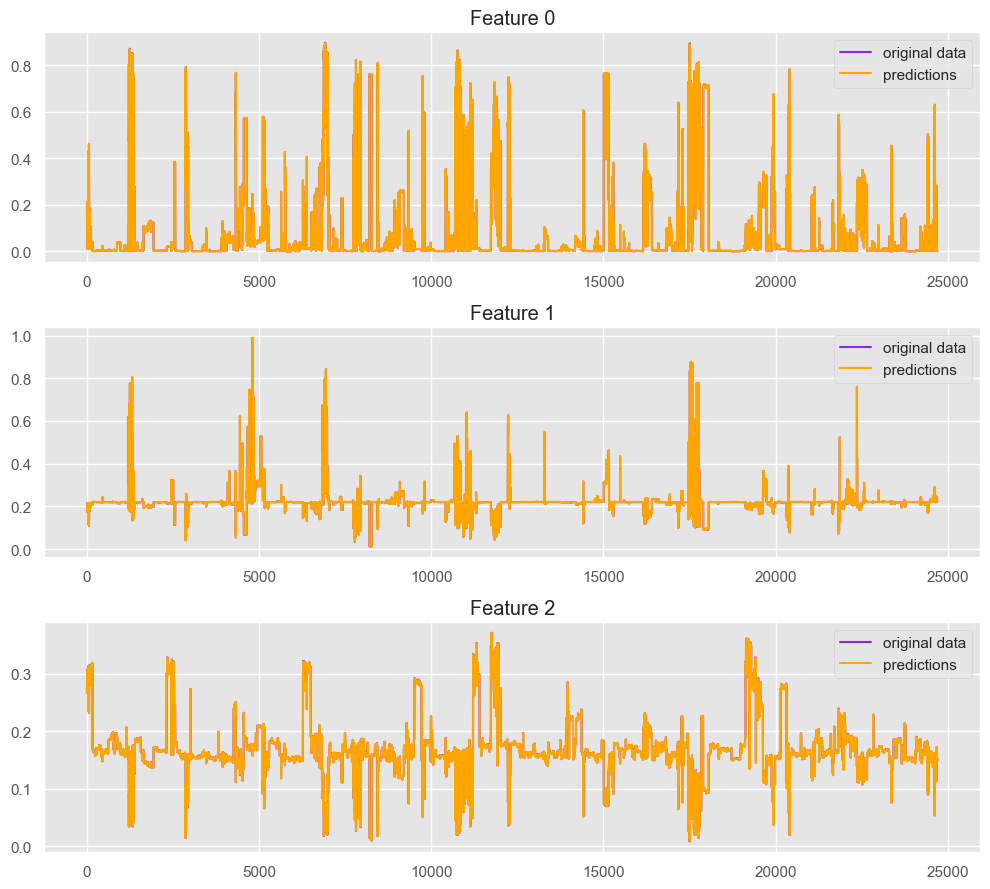

Epoch: 11  train loss: 8.481674574331856e-05  val loss: 5.285203013550653e-06  time: 157.86887311935425 


Epoch: 12  train loss: 8.066337431447026e-05  val loss: 0.00011823658231886192  time: 156.5911922454834 


Epoch: 13  train loss: 7.518366744991469e-05  val loss: 1.2996544908615358e-05  time: 156.73759269714355 


Epoch: 14  train loss: 7.048132594667006e-05  val loss: 2.1713465324525664e-06  time: 156.6812448501587 


Epoch: 15  train loss: 6.66825811668193e-05  val loss: 1.2694537690105074e-05  time: 156.67415761947632 


Epoch: 16  train loss: 6.612566469693349e-05  val loss: 7.739213803954722e-05  time: 156.8557529449463 


Epoch: 17  train loss: 5.7027418986212154e-05  val loss: 6.427332717625167e-06  time: 159.93902230262756 


Epoch: 18  train loss: 5.9547449036759616e-05  val loss: 3.1895907967845385e-05  time: 160.78088927268982 


Epoch: 19  train loss: 5.618134556869829e-05  val loss: 1.2033213068930615e-05  time: 181.17057418823242 


Epoch: 20  train loss: 5.3187489708097896e-05  val loss: 1.0833103824240185e-05  time: 178.0548071861267 


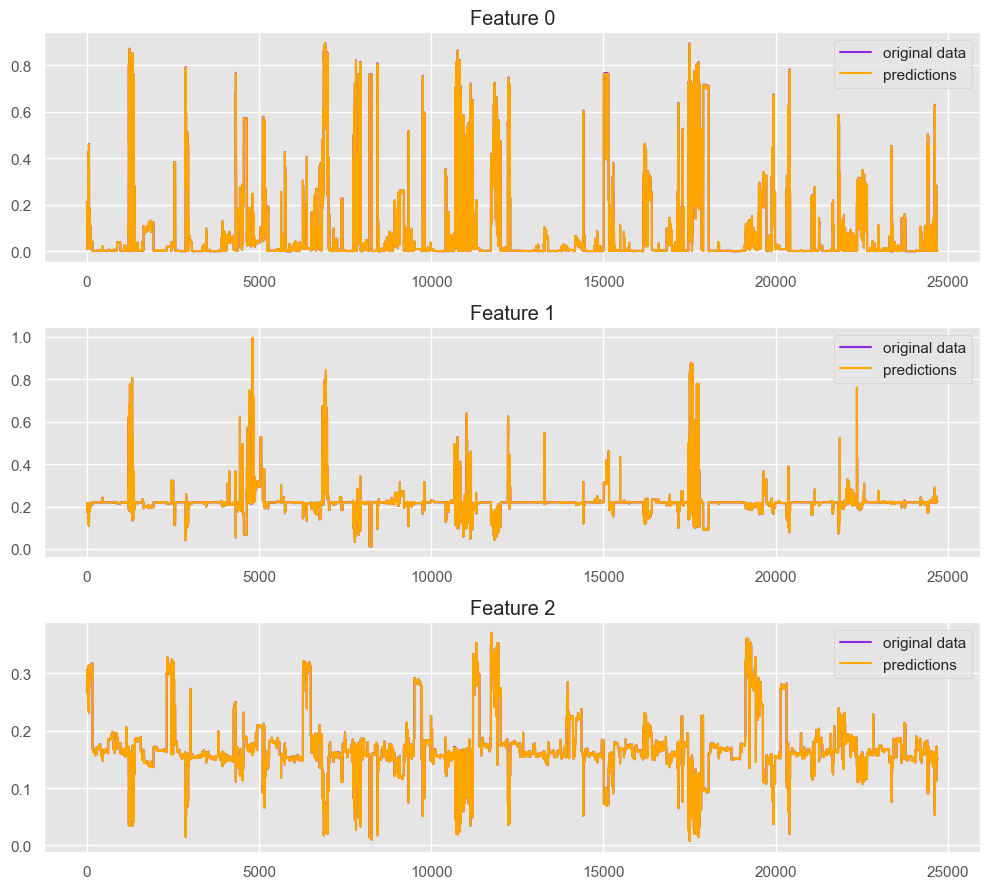

Epoch: 21  train loss: 5.095347901477964e-05  val loss: 3.0511633519482892e-06  time: 167.71283864974976 


Epoch: 22  train loss: 4.9372425586841e-05  val loss: 6.645874578691275e-06  time: 161.08022594451904 


Epoch: 23  train loss: 4.55082539182475e-05  val loss: 1.3942846401472462e-05  time: 169.25273537635803 


Epoch: 24  train loss: 4.69370104394184e-05  val loss: 1.5725787214970927e-06  time: 171.10060930252075 


Epoch: 25  train loss: 4.3181602907849654e-05  val loss: 5.416202512751012e-05  time: 172.43322587013245 


Epoch: 26  train loss: 4.173220797416219e-05  val loss: 4.1593148088869136e-05  time: 167.44764947891235 


Epoch: 27  train loss: 4.0083622436916423e-05  val loss: 0.00012707111679465674  time: 158.79408144950867 


Epoch: 28  train loss: 3.931696235851392e-05  val loss: 9.332087784754775e-06  time: 157.18832564353943 


Epoch: 29  train loss: 3.863317137601364e-05  val loss: 3.05202235170597e-05  time: 156.45527362823486 


Epoch: 30  train loss: 4.0525419552396774e-05  val loss: 5.059910177161738e-06  time: 157.3439769744873 


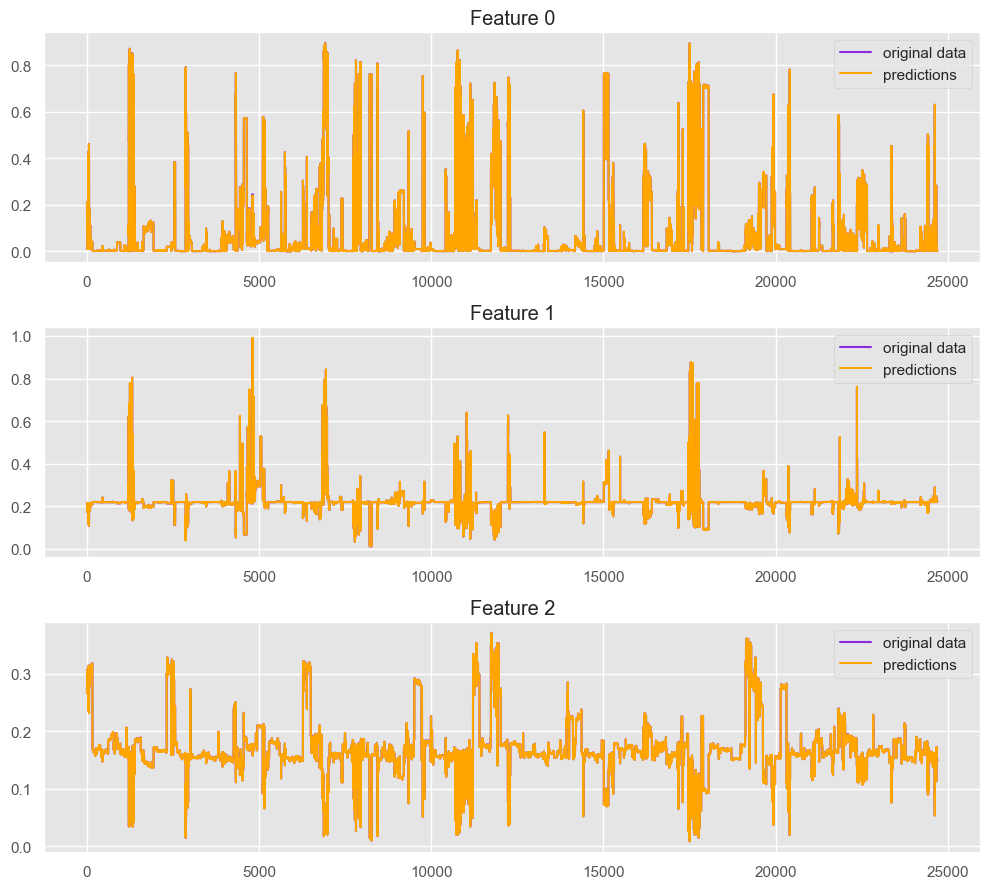

Epoch: 31  train loss: 3.6435119302626933e-05  val loss: 4.468321076995002e-06  time: 166.86611795425415 


Epoch: 32  train loss: 3.229584687165262e-05  val loss: 7.720940852520884e-06  time: 156.36024069786072 


Epoch: 33  train loss: 3.515086866355056e-05  val loss: 5.664701193811923e-06  time: 157.31421566009521 


Epoch: 34  train loss: 3.490078500004441e-05  val loss: 0.00023560179036493363  time: 156.603857755661 


Epoch: 35  train loss: 3.1444484438304066e-05  val loss: 1.1904686577392351e-05  time: 156.98144102096558 


Epoch: 36  train loss: 2.9315496709685362e-05  val loss: 3.527657895279995e-06  time: 156.26054310798645 


Epoch: 37  train loss: 3.2184436075678967e-05  val loss: 5.4030504473826234e-05  time: 156.51933097839355 


Epoch: 38  train loss: 2.8309036599564606e-05  val loss: 1.8670917310317077e-05  time: 157.36899304389954 


Epoch: 39  train loss: 2.7864567321868902e-05  val loss: 2.461458569680735e-06  time: 157.1657633781433 


Epoch: 40  train loss: 2.7538138184764212e-05  val loss: 7.485492787303703e-06  time: 157.23454308509827 


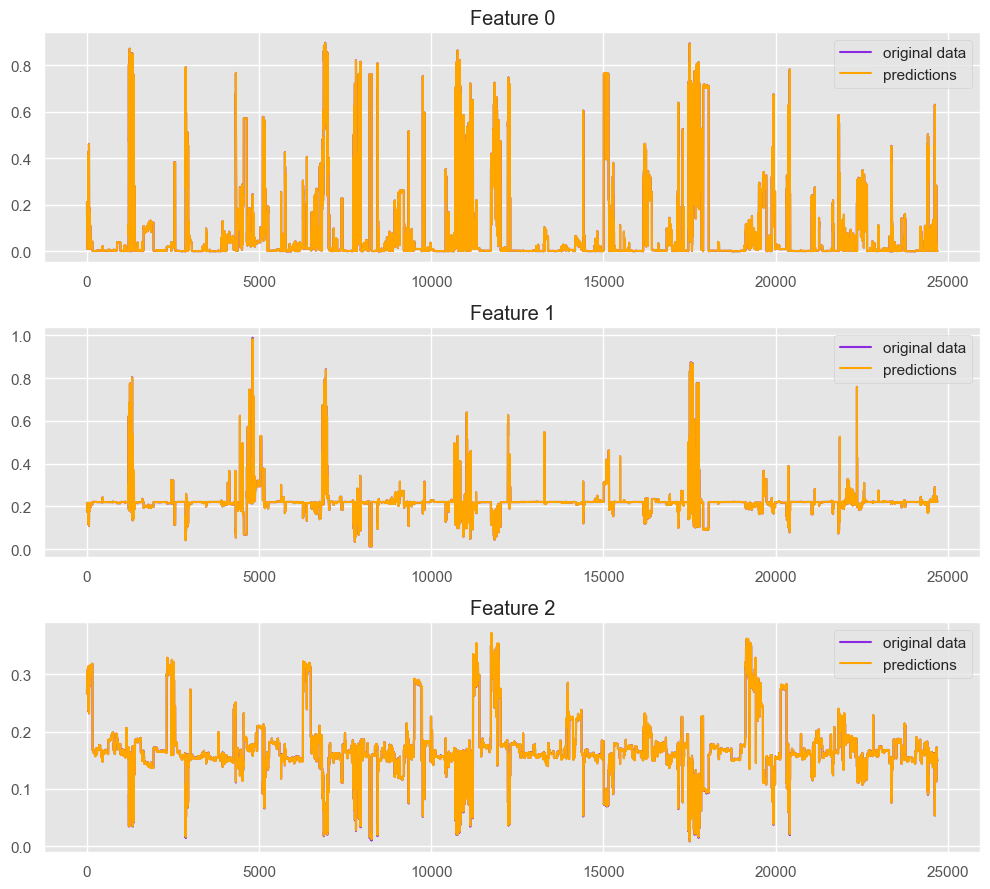

Epoch: 41  train loss: 2.841320894324658e-05  val loss: 3.3110292909678362e-06  time: 157.20255947113037 


Epoch: 42  train loss: 2.6336589351082296e-05  val loss: 1.1367802169759699e-05  time: 157.46788024902344 


Epoch: 43  train loss: 2.7027975267868008e-05  val loss: 4.691807210261978e-05  time: 158.0188627243042 


Early stopping at epoch 44


In [34]:
model, history = train_model(model, train_loader,val_loader , args.epoch, n_features, args)

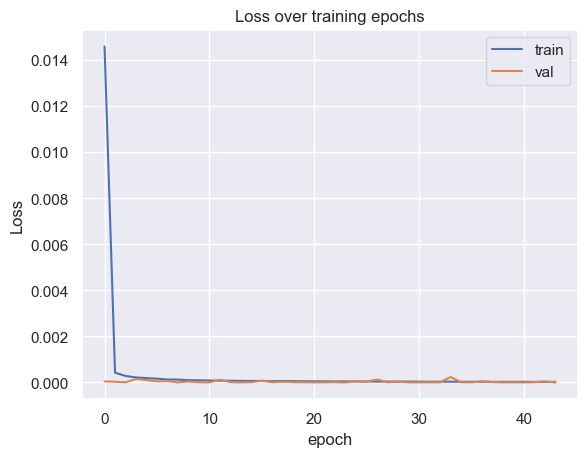

In [35]:
sns.set(style='dark')
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
# plt.ylim(0, 1)
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.grid()
plt.savefig('losses_3d.png', dpi=300)
plt.show();

In [36]:
MODEL_PATH = 'lstmae_3d.pth'
torch.save(model, MODEL_PATH)

In [27]:
model = torch.load('lstmae_3d.pth')
model = model.to(args.device)
model

LSTM_AUTO_ENCODER(
  (encoder): Encoder(
    (lstm1): LSTM(3, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [28]:
class Create_dataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=1):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.n_samples, self.n_features = self.data.shape
        self.dataset = self.create_dataset(self.data, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data.iloc[i:i+self.seq_len].values.astype(np.float32)
            sequences.append(torch.from_numpy(sequence))
        return DataLoader(sequences, batch_size=batch_size, shuffle=False)

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return len(self.data) - self.seq_len + 1

In [29]:
class encdataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=1):
        # data load
        self.data = data
        self.features = self.data.values.astype(np.float32)
        self.n_samples, self.n_features = self.data.shape
        self.seq_len = seq_len
        self.train_df = self.data[0:576000]
        self.val_df = self.data[576000:]
        
        # создание датасета
        self.train_dataset = self.create_dataset(self.train_df, batch_size)
        self.val_dataset = self.create_dataset(self.val_df, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data[i:i+self.seq_len].values  # Изменение здесь
            sequences.append(torch.from_numpy(sequence))
        dataset = DataLoader(sequences, batch_size=batch_size, shuffle=False)
        return dataset

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return self.n_samples


In [30]:
dataset = encdataset(df)
# train_loader = dataset.train_dataset
val_loader = dataset.val_dataset
seq_len = dataset.seq_len
n_features = dataset.n_features

In [31]:
anomaly = Create_dataset(anom)
anomaly_loader=anomaly.dataset

In [32]:
anomaly_loader

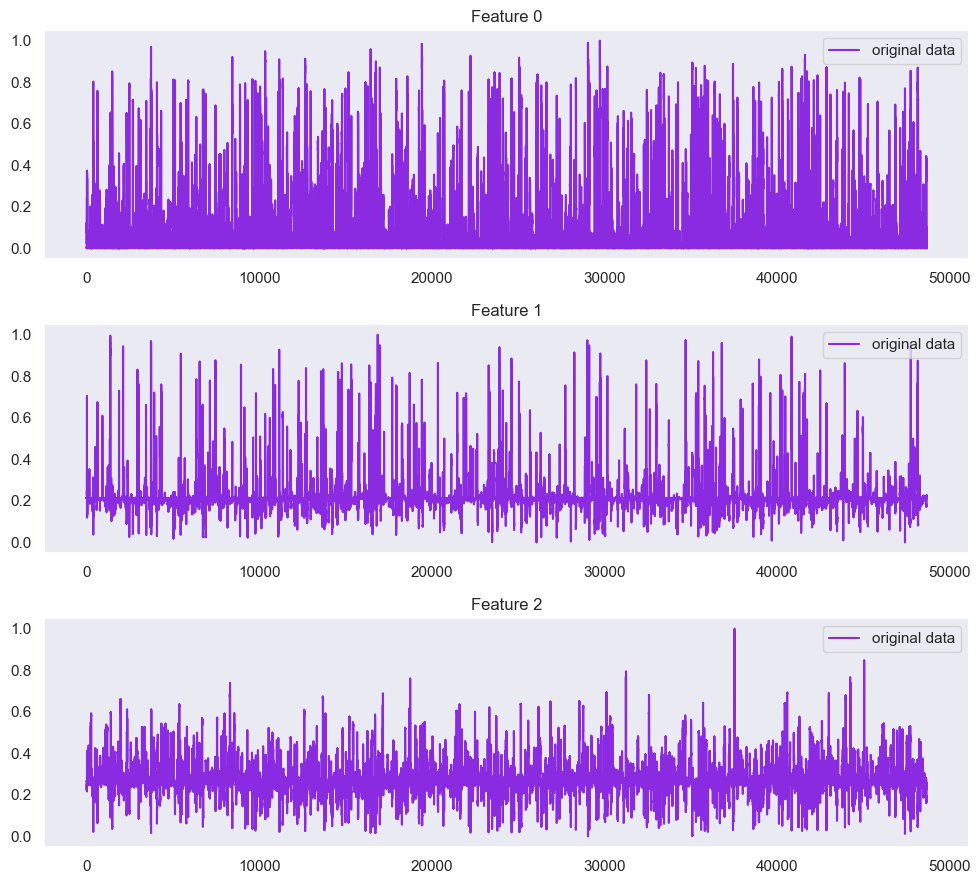

In [33]:
# 1. Извлечь данные из train_loader в виде numpy массива
anom_data = []
for batch in anomaly_loader:
    batch = batch.squeeze(1)  # убираем лишнее измерение
    batch = batch.numpy()  # преобразуем в numpy array
    for seq in batch:
        anom_data.append(seq)
anom_data = np.array(anom_data)

# 2. Перестроить данные в подходящий формат для построения графиков
anom_data = anom_data.reshape(-1, seq_len, n_features)

# 3. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 4. Построить график для каждой фичи
for i in range(n_features):
    line, = axs[i].plot(anom_data[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(anom_data[:, j, i], color='blueviolet')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line])  # Добавить легенду

plt.tight_layout()
plt.show()

In [34]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.MSELoss(reduction='sum').to(args.device)

    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device=args.device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [35]:
val_pred, val_losses = predict(model,val_loader)
# sns.displot(val_losses, bins=50, kde=True);

In [36]:
# train_pred, train_losses = predict(model,train_loader)
# # sns.displot(train_losses, bins=50, kde=True);

In [37]:
anom_pred, anom_losses = predict(model,anomaly_loader)
# sns.displot(anom_losses, bins=50, kde=True);

In [38]:
len(anom_losses)+len(val_losses)

73368

3d случай:

2e-9 -для лучшего детектирования выбытий

5e-8 -золотая середина

2d случай (v3):

2e-10 -для лучшего детектирования выбытий

1.3e-8 -золотая середина

In [39]:
Threshold = 5e-8

In [40]:
# corect_train= sum(l<= Threshold for l in train_losses)
# print(f'Correct normal predictions: {corect_train}/{len(train_loader)}')
# detected_train=corect_train/len(train_loader)
# print(f'correct detected normal: {detected_train}')
corect_normal= sum(l<= Threshold for l in val_losses)
print(f'Correct normal predictions: {corect_normal}/{len(val_loader)}')
detected_normal=corect_normal/len(val_loader)
print(f'correct detected normal: {detected_normal}')
corect_anomaly= sum(l> Threshold for l in anom_losses)
print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
detected_anomaly=corect_anomaly/len(anomaly_loader)
print(f'correct detected anomaly: {detected_anomaly}')

Correct normal predictions: 20883/24701
correct detected normal: 0.8454313590542893
Correct anomaly predictions: 41717/48667
correct detected anomaly: 0.8571927589537058


In [41]:
df['Failure']=0
anom['Failure']=1

In [45]:
th=np.arange( 2e-10,7e-8,1e-10)
th.shape

(698,)

In [46]:
corect_normal= sum(l<= th for l in val_losses)
print(f'Correct normal predictions: {corect_normal}/{len(val_loader)}')
detected_normal=corect_normal/len(val_loader)
print(f'correct detected normal: {detected_normal}')
corect_anomaly= sum(l> th for l in anom_losses)
print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
detected_anomaly=corect_anomaly/len(anomaly_loader)
print(f'correct detected anomaly: {detected_anomaly}')

Correct normal predictions: [    3    21    43    52    59    89   112   135   153   213   337   447
   513   559   595   652   717   759   799   855  1026  1291  1566  1738
  2017  2170  2331  2673  2874  3101  3341  3616  3989  4321  4581  4809
  5160  5590  5884  6208  6623  6961  7244  7490  7744  8113  8409  8793
  9049  9399  9796 10080 10458 11025 11763 12519 12987 13654 14580 15162
 15401 15531 15650 15704 15742 15833 15878 15900 15920 15944 15968 16000
 16034 16047 16069 16091 16107 16124 16154 16181 16192 16206 16216 16251
 16265 16294 16305 16323 16349 16363 16389 16429 16447 16463 16484 16502
 16511 16527 16555 16585 16600 16615 16622 16640 16655 16664 16674 16687
 16699 16710 16732 16741 16776 16790 16795 16802 16810 16819 16831 16846
 16865 16878 16887 16907 16927 16952 16983 17000 17009 17017 17035 17090
 17105 17116 17129 17140 17146 17173 17194 17200 17209 17218 17234 17246
 17256 17269 17286 17294 17306 17318 17324 17343 17350 17363 17373 17387
 17394 17406 17421 1743

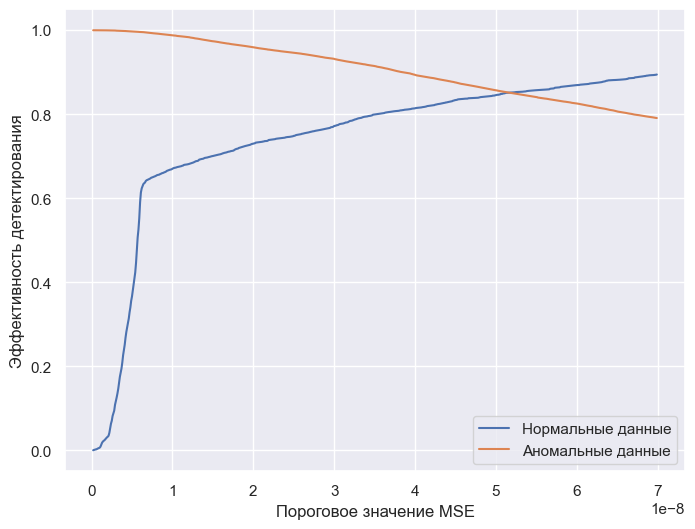

In [47]:
sns.set(style='dark')
plt.figure(figsize=(8,6))
plt.plot(th ,detected_normal)
plt.plot(th ,detected_anomaly)
plt.ylabel('Эффективность детектирования')
plt.xlabel('Пороговое значение MSE')
# plt.ylim(0, 1)
# plt.title('Зависимость эффективности модели от ошибки реконструкции по MSE')
plt.legend(['Нормальные данные','Аномальные данные'], loc='lower right')
plt.grid()
plt.savefig('threshhold_3d.png', dpi=300)
plt.show();

In [120]:
combined_df = np.concatenate((df[576000:], anom), axis=0)

In [121]:
combined_df = pd.DataFrame(combined_df, columns=df.columns)

In [122]:
combined_df.shape

(73368, 4)

In [123]:
X=combined_df.drop(['Failure'], axis=1)
y=combined_df['Failure']

In [124]:
combo = Create_dataset(X)
combo_loader=combo.dataset

In [125]:
losses=val_losses+ anom_losses

In [126]:
score = pd.DataFrame(index = X.index)
score['Loss'] = losses
score['Threshold'] = Threshold
score['Anomaly'] = score['Loss'] > score['Threshold']

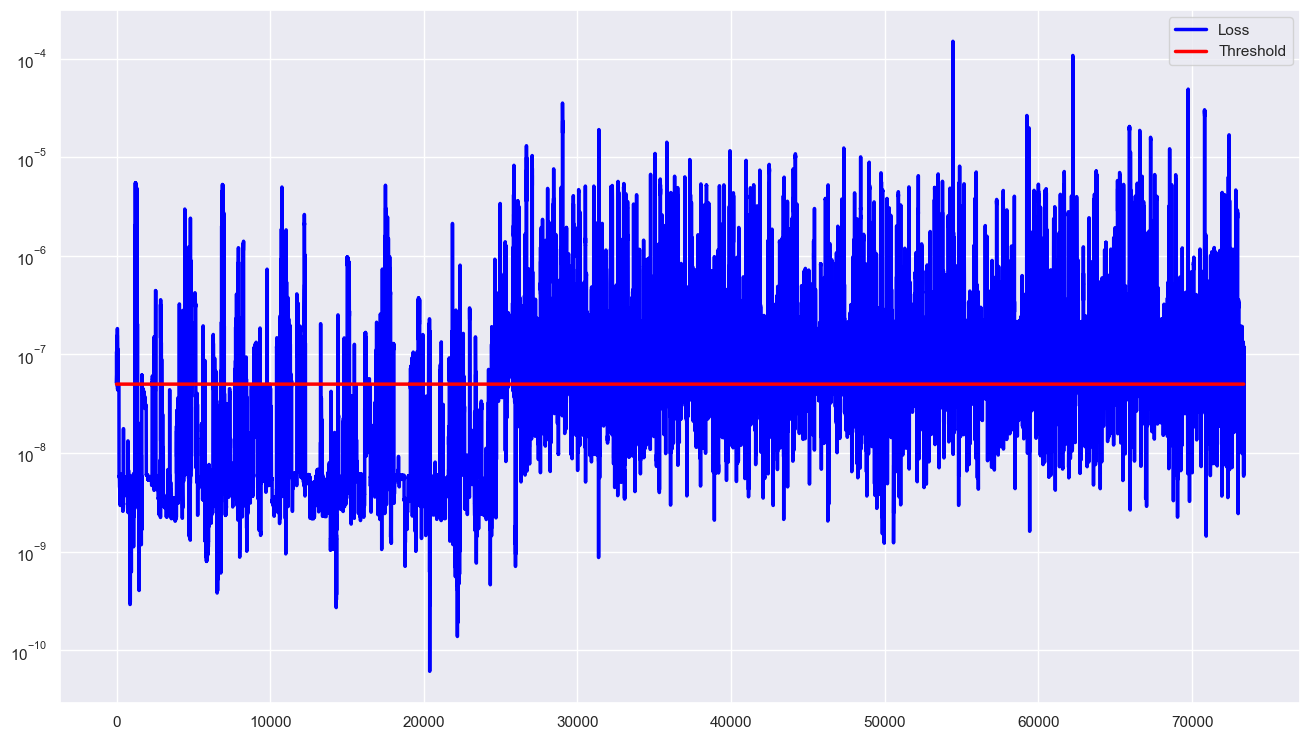

In [127]:
sns.set(style='dark')
score.plot(logy=True, figsize=(16,9), color=['blue','red'],linewidth=2.5)
# plt.savefig('score_plot_3d_failure.png', dpi=300)
plt.grid()
# Отображение графика
plt.show()

In [128]:
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score

In [129]:
def metrics(y_true,y_pred):
    acc=accuracy_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred, average='binary')
    roc_auc=roc_auc_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    
        # Создание DataFrame
    metrics_df = pd.DataFrame({
        'Метрика': ['Recall', 'Precision', 'F1', 'roc_auc', 'accuracy', 'detected normal', 'detected anomaly'],
        'Значение': [recall, precision, f1, roc_auc, acc, detected_normal, detected_anomaly]
    })

    # # Сохранение DataFrame в CSV
    metrics_df.to_csv('metrics/metrics_3d_balance.csv', index=False)
    return metrics_df

In [130]:
score.head()

,Loss,Threshold,Anomaly
0,1.061826e-07,5.000000e-08,True
1,9.776997e-08,5.000000e-08,True
2,5.121266e-08,5.000000e-08,True
3,5.987608e-08,5.000000e-08,True
4,5.987608e-08,5.000000e-08,True


In [131]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Failure, dtype: float64

In [132]:
y.shape

(73368,)

In [133]:
score['Anomaly'].shape

(73368,)

In [134]:
score['Anomaly']=score['Anomaly'].astype(int)

In [135]:
metrics(y, score['Anomaly'])


,Метрика,Значение
0,Recall,0.857193
1,Precision,0.916152
2,F1,0.885692
3,roc_auc,0.851312
4,accuracy,0.853233
5,detected normal,0.845431
6,detected anomaly,0.857193


In [115]:
# FPR=(len(val_loader)-corect_normal)/((len(val_loader)-corect_normal)+corect_normal)
# FPR
# TPR=(corect_anomaly)/(corect_anomaly+(len(val_loader)-corect_normal))
# TPR
# Recall=(corect_anomaly)/(corect_anomaly+(len(val_loader)-corect_normal))
# Recall
# Precision=(corect_anomaly)/(corect_anomaly+(len(anomaly_loader)-corect_anomaly))
# Precision
# F1=(2*Precision*Recall)/(Precision+Recall)
# F1

In [107]:
# # Создание DataFrame
# metrics_df = pd.DataFrame({
#     'Метрика': ['FPR', 'TPR', 'Recall', 'Precision', 'F1', 'roc_auc', 'accuracy', 'detected normal', 'detected anomaly'],
#     'Значение': [FPR, TPR, Recall, Precision, F1, roc_auc, acc, detected_normal, detected_anomaly]
# })

# # # Сохранение DataFrame в CSV
# metrics_df.to_csv('metrics/metrics_3d_failure.csv', index=False)

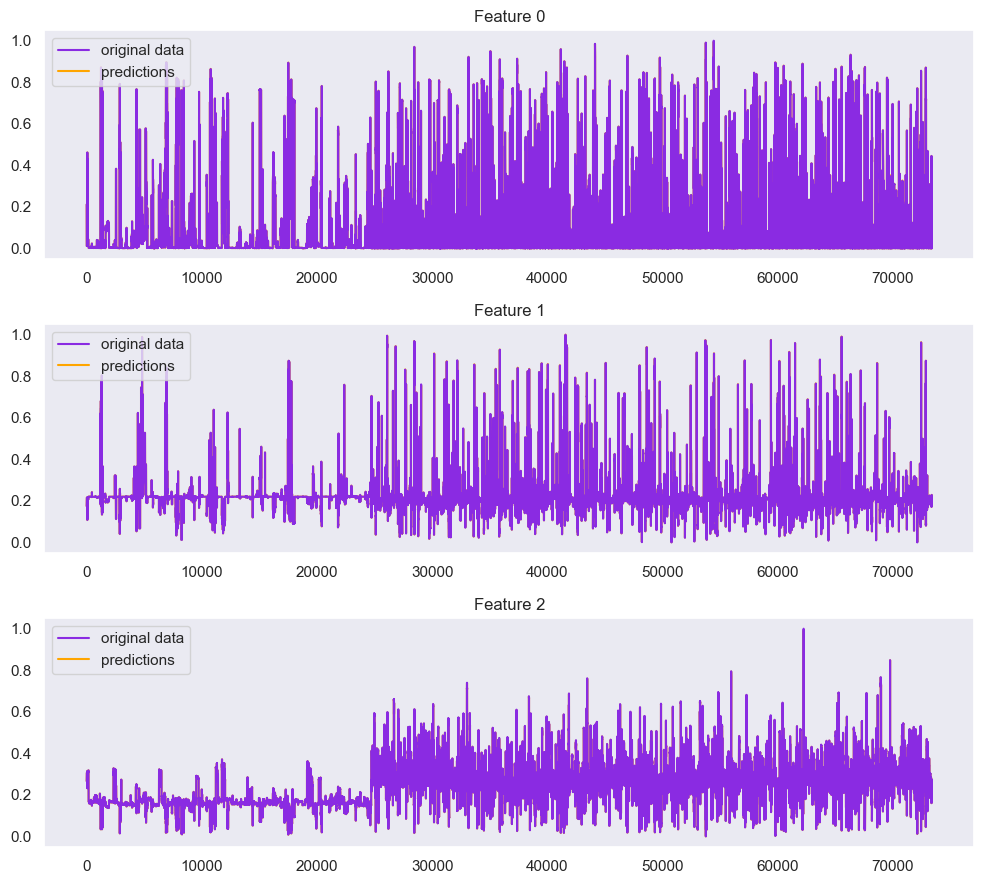

In [136]:
combo_data_np = torch.cat([batch for batch in combo_loader], dim=0).detach().cpu().numpy()

# 2. Перестроить данные в подходящий формат для построения графиков
combo_data_np = combo_data_np.reshape(-1, seq_len, n_features)

# 3. Получить предсказания модели
preds = []
with torch.no_grad():
    model = model.eval()
    for seq_true in combo_loader:
        seq_true = seq_true.to(args.device)
        seq_true = seq_true.reshape((-1, seq_len, n_features))

        seq_pred = model(seq_true)
        preds.append(seq_pred.cpu().numpy())
preds = np.concatenate(preds, axis=0)

# 4. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 5. Построить график для каждой фичи
for i in range(n_features):
    

    line2, = axs[i].plot(preds[:, 0, i], color='orange', label='predictions')
    line1, = axs[i].plot(combo_data_np[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(combo_data_np[:, j, i], color='blueviolet')
        axs[i].plot(preds[:, j, i], color='orange')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line1, line2])
# plt.savefig('preds/original 3d.png', dpi=300)
plt.tight_layout()

plt.show()
